# PDFs  at FPF

Need to obtain double differential cross section, $\frac{d^2\sigma(x,y,Q^2)}{dxdy}$

where x is Bjorken-x $\in \left[0,1\right]$, $Q^2$ is momentum transfer squared, and y is the fraction of energy transfered to the outgoing lepton with respect to incoming neutrino energy, i.e. , $ y = 1-E_l/E_{\nu}$. 

Want to bin events in a 3d space $x,y,Q^2$ (or $ E_{\nu})$ 

Ultimately, we will choose include nuclear effects, base PDF's, etc. but we will start with the simple case of scattering off free protons.

First generate csv of different x,y, $Q^2$ values.

Will start with a 10x10x10 grid with range 

$1{\rm GeV}^2< Q^2< {\rm TeV}^2$,

$0 < y < 1$,

and

$10^{-4}< x < 1 $

# Write $x,y, Q^2$ listings, for $\frac{d^2\sigma}{dxdy}$ to be computed in Yadism

In [1]:
import itertools 
import numpy as np
#n points in each variable --> n**3 evaluations
n = 10
m_N = 0.938

#choose y,x,log10(Q^2) range. Linearly spaced y, logspaced  x and Q^2
y = np.linspace(0,1,n)
x = np.logspace(-4,0,n)
logQ2_lower = -4;logQ2_upper = 6;
Q2 = np.logspace(logQ2_lower,logQ2_upper,n) #in GeV^2

#combine all combinations into an array
A = [x , y , Q2]
M = list(itertools.product(*A))
LX = np.zeros(n**3);Y = np.zeros(n**3);LQ2 = np.zeros(n**3)
data = np.zeros(shape = (n**3,3))
data = [ [0]*3 for i in range(n**3)]
for ii,m in enumerate(M):
    data[ii][0] = np.log10(M[ii][0])
    data[ii][1] =          M[ii][1]
    data[ii][2] = np.log10(M[ii][2])
    
#save and write to xyQ2.csv
import csv  
header = ['Log10(x)','y','Log10(Q^2 / GeV^2)']
stringsave = 'xyQ2_2.csv'
with open(stringsave, 'w') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)
    # write the data
    writer.writerows(data)

# Load in $\frac{d^2\sigma}{dxdy}(x,y, Q^2) $, load in neutrino spectra, interpolate each for custom binning. Also a short script for experimental target details
Need to have d2sigma(x,y,Q2) from https://github.com/juanrojochacon/FPF-WG1/blob/main/results/diff_xsecs_a1.txt

Need to have "Fluxes" folder from https://github.com/KlingFelix/FastNeutrinoFluxSimulation/tree/main/Fluxes 

In [2]:
import os
import matplotlib.pyplot as plt
import scipy
import pdb
import numpy as np
from scipy.interpolate import interpn
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Define some constants 
G_fermi = 1.166e-5 
MW = 80.379
prefac_const = G_fermi**2 / (4 * np.pi)

#load input points and differential cross sections
with open('diff_xsecs_a1.txt') as f:
    lines = f.readlines()
    x_list = np.array([float(lines[ii+1].split()[0]) for ii in np.arange(len(lines)-1)])
    y_list = np.array([float(lines[ii+1].split()[1]) for ii in np.arange(len(lines)-1)])
    Q2_list_gev2 = np.array([float(lines[ii+1].split()[2]) for ii in np.arange(len(lines)-1)])
    
    #prefactor for previous definition of xsec. No longer used but keeping for posterity
    prefactor = 4 * prefac_const * 1 / (2 * x_list * (1 + (Q2_list_gev2 / MW**2))**2)
    
    #change prefactor 2 1
    prefactor = 1
    xsecnu_invgev2 = prefactor * np.array([float(lines[ii+1].split()[3]) for ii in np.arange(len(lines)-1)])
    xsecnub_invgev2 = prefactor * np.array( [float(lines[ii+1].split()[4]) for ii in np.arange(len(lines)-1)])

#organize into 3D matrix (for interpolation)    
xu = np.unique(x_list);yu = np.unique(y_list);qu = np.unique(Q2_list_gev2);
dsigmanu_dxdy = np.zeros(shape=(10,10,10));dsigmanub_dxdy = np.zeros(shape=(10,10,10))
count = 0
for ix,x in enumerate(xu):
    for iy,y in enumerate(yu):
        for iq,q in enumerate(qu):
            dsigmanu_dxdy[ix,iy,iq] = xsecnu_invgev2[count]
            dsigmanub_dxdy[ix,iy,iq] = xsecnub_invgev2[count]
            count +=1
            

            

#write interpolating function
#yadism outputs d2sigma/dx/dq2 * 1/4. Here I account for 1/4 factor
points = (xu,yu,qu)
def dsigmanudxdq2_interp_invgev2(x,y,q2):
#     prefactor = prefac_const * 1 / (x * (1 + (q2 / MW**2))**2)
    return interpn(points,dsigmanu_dxdy,(x,y,q2)) 

def dsigmanubdxdq2_interp_invgev2(x,y,q2):
    return interpn(points,dsigmanub_dxdy,(x,y,q2))   

#write dsigmadxdy = dsigmadxdq2 * dq2 / dy
def dsigmanudxdy_interp_invgev2(x,y,q2):
    E_nu = q2 / (2 * y * m_N * x)
    jacobian = 1 * (2 * E_nu * m_N * x)
    return dsigmanudxdq2_interp_invgev2(x,y,q2) * jacobian

def dsigmanubdxdy_interp_invgev2(x,y,q2):
    E_nu = q2 / (2 * y * m_N * x)
    jacobian = 1 * (2 * E_nu * m_N * x)
    return dsigmanubdxdq2_interp_invgev2(x,y,q2) * jacobian
    
#specify experiment {FASERv, FASERv2, FLArE10, FLArE100,SND@LHC}
#gives neutrino flux (dN vs E) at experiment for neutrino with flavor {ve,vmu,vtau} = {12,14,16}
def dn_de(experiment,pid, raw = 0):
    folder = os.path.join('Fluxes',experiment);L = os.listdir(folder)
    file = [f for f in L if '_'+str(pid) in f and 'CC' not in f];file = os.path.join(folder,file[0])
    with open(file) as f:
        lines=f.readlines()
        e_gev = np.array([float(lines[ii].split()[0]) for ii in np.arange(len(lines))])
        N_perbin = np.array([float(lines[ii].split()[1]) for ii in np.arange(len(lines))])
        
    #energies are evenly log10spaced. get dn_de by dividing by bin width
    width = e_gev * (e_gev[2]/e_gev[1] - 1)
    dnde_invgev = N_perbin / width
    if raw ==1:
        return e_gev, N_perbin
    else:
        return e_gev, dnde_invgev

#what is proton density and length of each experiment?
def experiment_nL(experiment):
    experiments = ['FASERv', 'FASERv2', 'FLArE10', 'FLArE100','SND@LHC']
    index = experiments.index(experiment)
    Na = 6.02e23
    Z_Ar = 18;g_per_cm3_Ar = 1.4;MM_Ar = 39.9
    Z_W = 74;g_per_cm3_W = 19.3;MM_W = 183
    
    #density / Molar Mass * Avogardo * Z = protons / cm^3
    tungsten_proton_density = g_per_cm3_W / MM_W * Na * Z_W 
    LAr_proton_density = g_per_cm3_Ar / MM_Ar * Na * Z_Ar
    
    #density / Molar Mass * Avogardo * MolarMass = nucleons / cm^3
    tungsten_nucleon_density = g_per_cm3_W / MM_W * Na * MM_W 
    LAr_nucleon_density = g_per_cm3_Ar / MM_Ar * Na * MM_Ar
    
    #fasernu, SND are tungsten, Flare is liquid argon.
    proton_densities_percm3 = [tungsten_proton_density,tungsten_proton_density,LAr_proton_density,LAr_proton_density,tungsten_proton_density]
    nucleon_densities_percm3 = [tungsten_nucleon_density,tungsten_nucleon_density,LAr_nucleon_density,LAr_nucleon_density,tungsten_nucleon_density]
    
    #Experimental lengths in cm. (What is AdvSND length? I set to zero for now)
    lengths_cm = np.array([1,2,7,30,0])*100
    return nucleon_densities_percm3[index],lengths_cm[index]

# Calculate CC Event rate
With $x = \frac{Q^2}{2m_N (E_{\nu}-E_l)}$, $y = 1 - E_l/E_{\nu} = \frac{Q^2}{2m_N E_{\nu }x}$. 
where $m_N$ is the proton mass.

Total number of DIS events $N_{tot} = N_{\nu} \times L n_T \sigma$. Where $N_{\nu}$ is the number of incident neutrinos, $L$ is the length of the detector / target, $n_T$ is the target number density, and $\sigma$ is the 
neutrino-nucleon interaction cross section. For this first pass, we are treating the target as free protons with a number density determined by the mateiral (Tungsten or LAr).

Write $N_{\nu} = \int \frac{dN_{\nu}}{dE_{\nu}} dE_{\nu}$ 
and
$\sigma = \int \int \frac{d^2\sigma(x,y,Q^2)}{dxdy} dx dy$

Output from Yadism is (i.e. under xsec_nu column in diff_xsecs_a1.txt)

Update: Have properly included the prefactors from $xsec_{old}$ in $xsec_{new}$. So now output from diff_xsecs_a1_iso.txt is $xsec_{new}$

$$xsec_{old} = \frac{d^2\sigma}{dx dQ^2}\frac{1}{4}\left(\frac{G_{\rm F}^2}{4 \pi}\frac{1}{2 x (1+ Q^2 / m_W^2)^2}\right)^{-1} [{\rm GeV^{-6}}]$$
$$xsec_{new} = \frac{d^2\sigma}{dx dQ^2} [{\rm pb ~/~ GeV^2}]$$


Write the number of events per bin, normalized by target density and length, as

$$N_{\rm bin}/(n_T L) =\int_{E_{\nu}} \int_y \int_x \frac{dN_{\nu}}{dE_{\nu}}\frac{d^2\sigma(x,y,E_{\nu})}{dxdy}dE_{\nu} dx dy = \int_{E_{\nu}} \int_y \int_x g(x,E_{\nu},y) dE_{\nu} dx dy
\\
=\int_{E_{\nu}} \int_{Q^2} \int_x \frac{dN_{\nu}}{dE_{\nu}}\frac{d^2\sigma(x,E_{\nu},Q^2)}{dxdy} \frac{1}{2m_NE_{\nu}x}dE_{\nu} dx dQ^2 = \int_{E_{\nu}} \int_{Q^2} \int_x f(x,E_{\nu},Q^2) dE_{\nu} dx dQ^2
$$

where the second line follows from $y = \frac{Q^2}{2m_N E_{\nu }x}$, $dy = \frac{dQ^2}{2m_NE_{\nu}x}$.


We then do a MC integration per bin, depending on the choice of binning.

For bins in $x,E_{\nu},y$ write integrand as $g(x,E_{\nu},y) = \frac{dN_{\nu}}{dE_{\nu}}\frac{d^2\sigma(x,y,E_{\nu})}{dxdy} $


For bins in $x,E_{\nu},Q^2$ write integrand as $f(x,E_{\nu},Q^2) = \frac{dN_{\nu}}{dE_{\nu}}\frac{d^2\sigma(x,E_{\nu},Q^2)}{dxdy} \frac{1}{2m_NE_{\nu}x} = \frac{dN_{\nu}}{dE_{\nu}}\frac{d^2\sigma(x,E_{\nu},Q^2)}{dxdQ^2}  $

For MC integration, pick $N$ random points from bin on a uniform distribution, $(x_i, E_{\nu,i},y_i)$ so 

$$N_{\rm bin}\approx n_T~L \times \frac{V}{N}\sum_i^N~g(x_i, E_{\nu,i},y_i)$$ 

Where $V$ is the volume element of the bin.

# Now define function N_bin($x_{bin},E_{\nu,bin},y_{bin})$), the number of events in a particular bin. 
We currently bin in x, $E_{\nu}$, $Q^2$. Scroll down to N_bin_alt function
Also dependent on experiment, and neutrino flavor

In [3]:
from scipy.integrate import nquad
from scipy.interpolate import interp1d
import random

#bick x_bin, Enu_bin,y_bin, experiment, particleid = pid = neutrino flavor , and N MC samples.
#default to fasernu and muon neutrinos for now
#Worked Example in next cell
def N_bin(x_bins,Enu_bins,y_bins,experiment = 'FASERv',pid=14,N = 100000):
    #check if antineutrino
    anti = 1 if pid < 0 else 0;
    
    #target mass and experiment. 0.938 for proton.
    m_N = 0.938 ;
    
    #get experimental geometry
    n,L = experiment_nL(experiment)
    invgev2_in_cm2 = 3.89e-28

    #interpolate to get dn_de
    e_gev,dnde_invgev = dn_de(experiment,pid);
    dn_de_interp = interp1d(e_gev,dnde_invgev,fill_value = 0)

    #write g function for x, y, E_nu binning. 
    if anti ==0:
        def g(x,Enu,y):
            q2 = y*(2*m_N*Enu*x)
            return dn_de_interp(Enu) * dsigmanudxdy_interp_invgev2(x,y,q2) 
    elif anti ==1:
        def g(x,Enu,y):
            q2 = y*(2*m_N*Enu*x)
            return dn_de_interp(Enu) * dsigmanubdxdy_interp_invgev2(x,y,q2) 

    #MC Integration
    #volume of bin
    volume = (x_bins[1]-x_bins[0]) * (Enu_bins[1] - Enu_bins[0]) * (y_bins[1] - y_bins[0])
    
    #generate random numbers in x,Enu,y 
    x_array = np.random.uniform(x_bins[0],x_bins[1],size = N)
    Enu_array = np.random.uniform(Enu_bins[0],Enu_bins[1],size = N)
    y_array = np.random.uniform(y_bins[0],y_bins[1],size = N)
    
    #evaluate integrand at points
    integrand = g(x_array,Enu_array,y_array)
    return sum(integrand) * volume / N * n * L * invgev2_in_cm2




In [4]:
#Example for 1 bin
N = 100000
x_bins = np.array([1e-1,1e0])
Enu_bins = [10**2.5, 10**3]
y_bins = [0.1,.5]
pid = 14;
experiment = 'FASERv'
N_bin(x_bins,Enu_bins,y_bins);

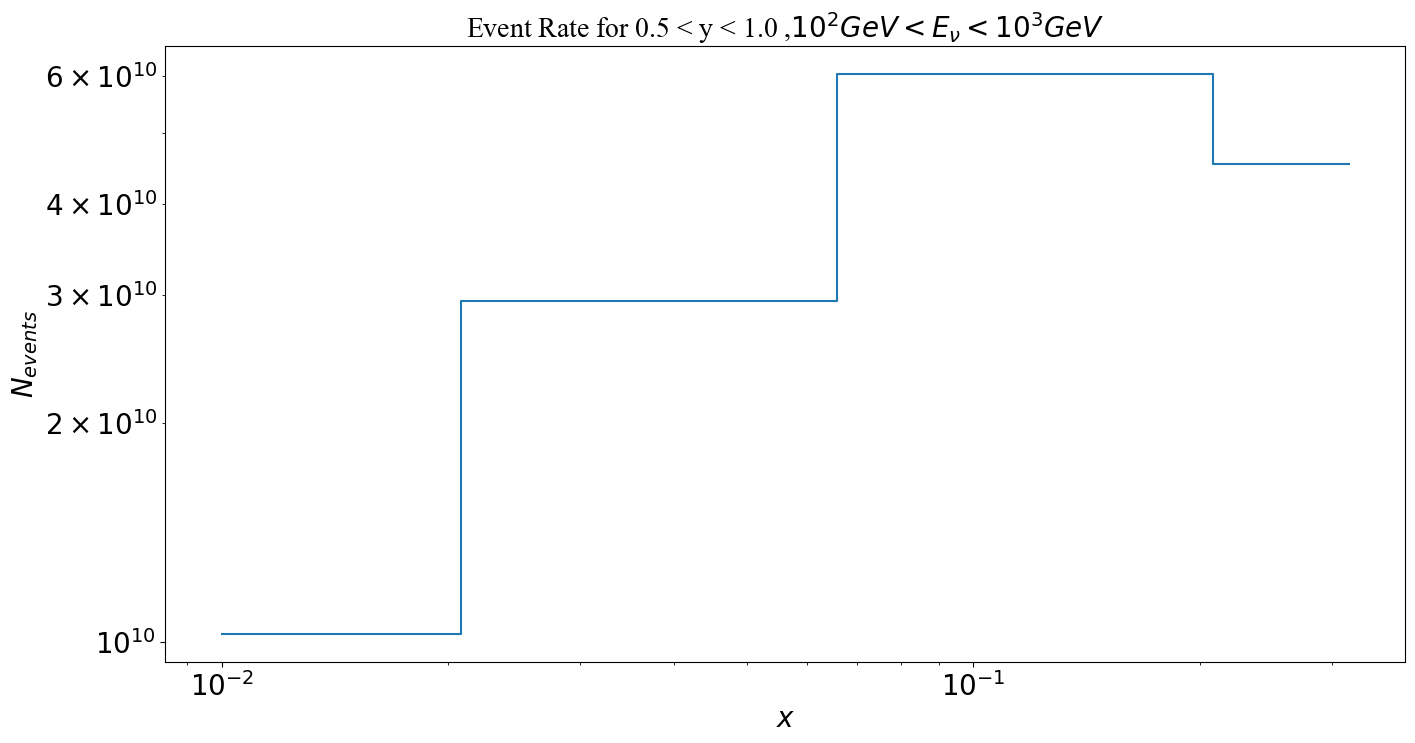

In [5]:
#make plots for a few different xbins
x_bins_array = np.logspace(-2,0,5);
mt = 0.938;m_N = mt

Enu_bins_array = np.array([10**2.5,10**3])
y_bins_array = np.array([0.5,1])
neutrinos = np.array([14,-14])
N_array = np.zeros_like(x_bins_array[:-1])
for ix,(x_lower,x_upper) in enumerate(zip(x_bins_array[:-1],x_bins_array[1:])):
    for y_lower,y_upper in zip(y_bins_array[:-1],y_bins_array[1:]):
        for Enu_lower,Enu_upper in zip(Enu_bins_array[:-1],Enu_bins_array[1:]):
            x_bins = [x_lower,x_upper];y_bins = [y_lower,y_upper];Enu_bins = [Enu_lower,Enu_upper]
#             print(x_lower,ix)
            
            N_events = N_bin(x_bins,Enu_bins,y_bins,N = 100000)
#             print(N_events)
            N_array[ix] = N_events
#             print(N_events,x_bins)
    
csfont = {'fontname':'Times New Roman','size':20}
plt.figure(figsize = (16,8))
plt.step(x_bins_array[:-1],N_array,where='mid')
plt.xscale('log');plt.yscale('log')
plt.ylabel(r'$N_{events}$',**csfont)
plt.xlabel(r'$x$',**csfont)
plt.title(r'Event Rate for %0.1f < y < %0.1f ,$ 10^{%0.0f} GeV < E_{\nu} < 10^{%0.0f} GeV$'\
          %(y_bins_array[0],y_bins_array[1],np.log10(Enu_bins_array[0]),np.log10(Enu_bins_array[1]) ),**csfont)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

# Alternate function which will bin events in $x,E_{\nu},Q^2$ (this is the main function we use with .txt file output)

In [6]:
#uses f(x,y,Enu) defined above. Used if you want bins in x,y,Q^2
from scipy.integrate import nquad
from scipy.interpolate import interp1d
import random
def N_bin_alt(x_bins,Enu_bins,Q2_bins,experiment = 'FASERv',pid=14,N = 10000000,total_xsec = 0,m_N = 0.938):
    #check if antineutrino
    anti = 1 if pid < 0 else 0;
    
    #target mass and experiment. 0.938 for proton.
    invgev2_in_cm2 = 3.89e-28
    cm2_in_pb = 1e-36
    
    #get experimental geometry
    n,L = experiment_nL(experiment)

    #interpolate to get dn_de
    e_gev,dnde_invgev = dn_de(experiment,pid);
    dn_de_interp = interp1d(e_gev,dnde_invgev,fill_value = 0)

    #write g function for x, y, E_nu binning. 
    if anti ==0:
        def f(x,Enu,q2):
            y = q2/(2*mt*Enu*x)
#             print(Enu,y,x,q2)
            return dn_de_interp(Enu) * dsigmanudxdq2_interp_invgev2(x,y,q2)
    elif anti ==1:
        def f(x,Enu,q2):
            y = q2/(2*m_N*Enu*x)
            return dn_de_interp(Enu) * dsigmanubdxdq2_interp_invgev2(x,y,q2) 
    

    #MC Integration
    #volume of bin
    volume = (x_bins[1]-x_bins[0]) * (Enu_bins[1] - Enu_bins[0]) * (Q2_bins[1] - Q2_bins[0])
    
    #generate random numbers in x,Enu,y 
    x_array = np.random.uniform(x_bins[0],x_bins[1],size = N)
    Enu_array = np.random.uniform(Enu_bins[0],Enu_bins[1],size = N)
    Q2_array = np.random.uniform(Q2_bins[0],Q2_bins[1],size = N)
    y_array = Q2_array / (2 * m_N * Enu_array * x_array)
    locs = np.where(y_array < 1)
    x_array = x_array[locs];Enu_array = Enu_array[locs];Q2_array = Q2_array[locs]
    acceptance = len(locs[0]) / N
#     print('Acceptance is: ',acceptance)
    
    #evaluate integrand at points
    integrand = f(x_array,Enu_array,Q2_array)
#     print('N/10^3 is ', sum(integrand) * volume / N * n * L * invgev2_in_cm2/1e3)
#     print('acc rate',len(locs[0]))
    xavg = np.mean(x_array);q2avg = np.mean(Q2_array);Enuavg = np.mean(Enu_array) 
    
    return sum(integrand) * volume / len(locs[0]) * n * L * cm2_in_pb,acceptance,N,xavg,q2avg,Enuavg






In [12]:
#bins in x, q2, Enu
m_N = 0.938;mt = 0.938
x_edges = np.logspace(-4,0,30)
Q2_edges = np.array([4,10**1,10**2,10**3,10**4,10**5])
Enu_edges = np.logspace(np.log10(11.336355),np.log10(5698.274),2)
pid = 14
experiment = 'FASERv'
stringsave = 'binned_events_%s_%s.txt' %(experiment,str(pid))
myfile = open(stringsave,'w')
if pid < 0:
    sigma = dsigmanubdxdq2_interp_invgev2
else:
    sigma = dsigmanudxdq2_interp_invgev2


myfile.write(
    f"{'x_lower':<15} {'x_upper':<15} {'x_avg':<15}"
    f"{'Q2_lower[GeV^2]':<20} {'Q2_upper[GeV^2]':<20} {'Q2_avg[GeV^2]':<20}"
    f"{'E_nu_lower[GeV]':<20} {'E_nu_upper[GeV]':<20} {'E_nu_avg[GeV]':<20}"
    f"{'d^sigma/dxdQ2(x_avg,Q2_avg,Enu_avg) / GeV^-2':<55}"
    f"{'N_events':<15} {'N_events_errs = Sqrt[N_events]':<35} {'MC_Samples'} \n"
)

N_sum = 0
flag_1k = 0
#write all bins, including ones with no events
plot_all_bins = 0
for ix,x_lower in enumerate(x_edges[:-1]):
    for iq,q2_lower in enumerate(Q2_edges[:-1]):
        for ie,E_lower in enumerate(Enu_edges[:-1]):
#             print(ie)
            x_upper,q2_upper,E_upper = x_edges[ix+1],Q2_edges[iq+1],Enu_edges[ie+1]
            x_bin = [x_lower,x_upper];q2_bin = [q2_lower,q2_upper];Enu_bin = [E_lower,E_upper];
#             print('x:',x_bin,'| q:',q2_bin,'| Enu:',Enu_bin)
            N,acceptance,Nsamples,xavg,q2avg,Enuavg = N_bin_alt(x_bin,Enu_bin,q2_bin,pid = pid,experiment = experiment)
            N_sum += np.nan_to_num(N)
            x_mid,q2_mid,Enu_mid = np.mean(x_bin),np.mean(q2_bin),np.mean(Enu_bin)
            y_mid = q2_mid / (2 * m_N * Enu_mid * x_mid)
            yavg = q2avg / (2 * m_N * Enuavg * xavg)
#             pdb.set_trace()
            
            if (np.nan_to_num(N)>0 | (plot_all_bins==1)):
                if yavg >1:
                    dsigma_mid = np.nan
                else:
#                     print(xavg,yavg,q2avg)
                    dsigma_mid = sigma(xavg,yavg,q2avg)
                if np.nan_to_num(N) > 1e3:
                    flag_1k += 1
#                 
                    
                if np.nan_to_num(N) > 10:
                    myfile.write(
                        f"{format(x_lower, '.6e'):<15} {format(x_upper, '.6e'):<15} {format(xavg, '.6e'):<15}"
                        f"{format(q2_lower, '.6e'):<20} {format(q2_upper, '.6e'):<20} {format(q2avg, '.6e'):<20}"
                        f"{format(E_lower, '.6e'):<20} {format(E_upper, '.6e'):<20} {format(Enuavg, '.6e'):<20}"
                        f"{format(float(dsigma_mid), '.6e'):<55}"
                        f"{format(float(np.nan_to_num(N)), '.6e'):<15} {format(float(np.sqrt(np.nan_to_num(N))), '.6e'):<35}"
                        f"{format(float(np.nan_to_num(acceptance)) * Nsamples, '.6e')} \n"
                    )
                
myfile.close()
print(N_sum)
#function to write summary at the top
def line_prepender(filename, line):
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(line.rstrip('\r\n') + '\n' + content)
n,L = experiment_nL(experiment)
summary_line = 'Experiment = %s | Neutrino = %s | Exp. Target density (nucleons / cm3) = 10^(%0.1f) | Exp. Target Length = %0.0f cm | Total Events = %0.1f'  %(experiment, str(pid),np.log10(n),L,N_sum)      
line_prepender(stringsave,summary_line)
print(flag_1k)

/tmp/ipykernel_32878/419060096.py:52: RuntimeWarning: invalid value encountered in double_scalars
  return sum(integrand) * volume / len(locs[0]) * n * L * cm2_in_pb,acceptance,N,xavg,q2avg,Enuavg


2984.2793000629817
0


# Check the total cross section

In [ ]:
N = 1000000
A = 1
x_array = np.random.uniform(1e-4,1,size = N)
y_array = np.random.uniform(0,1,size = N)
E_test = 5e4
mt = 0.938*A;m_N = mt
q2_array = 2 * mt*  E_test * x_array * y_array
locs = np.where((q2_array >= 1) & (q2_array<1e6))
x_array = x_array[locs];y_array = y_array[locs]
volume = 1 * 1
invgev2_pb = 3.89e-28 * 1e36
def dsigmadxdy_enu(x,y,Enu):
    mt = 0.938*A
    s = mt**2 + 2*mt*Enu
    q2 = 2 * mt * Enu * x * y
    
    return dsigmanudxdy_interp_invgev2(x,y,q2)*4
integrand = dsigmadxdy_enu(x_array,y_array,E_test)
print('Cross section at %0.0f is %0.4f pb ' %(E_test,sum(integrand) * invgev2_pb * volume / len(locs[0])) )

def dsigmadxdq2_enu(x,Q2,Enu):
    mt = 0.938*A
    s = mt**2 + 2*mt*Enu
    y = Q2 / (2 * mt * Enu * x)    
    return dsigmanudxdq2_interp_invgev2(x,y,Q2)*4

E_test = 5e3
x_array = np.random.uniform(1e-4,1,size = N)
q2_array = np.random.uniform(1,1e6,size = N)

y = q2_array / (2 * mt * E_test * x_array)
locs = np.where((y > 0) & (y < 1));x_array = x_array[locs];q2_array = q2_array[locs];
volume = (max(x_array) - min(x_array)) * ( max(q2_array) - min(q2_array))
integrand = dsigmadxdq2_enu(x_array,q2_array,E_test)
print('Cross section at %0.0f is %0.4f pb ' %(E_test,sum(integrand) * invgev2_pb * volume / len(locs[0])) )
